In [3]:
import torch
import numpy as np
import torch.nn as nn
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import torchvision.transforms as T
import cv2

from torchvision.transforms import Compose
from dpt.models import DPTDepthModel
from dpt.transforms import Resize, NormalizeImage, PrepareForNet
import util.io

import torchvision
top = T.ToPILImage()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/ubuntu/anaconda3/envs/max_2_0/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [4]:
model = DPTDepthModel(
    path=None,# './weights/dpt_hybrid-midas-501f0c75.pt',
    backbone="vitb_rn50_384",
    non_negative=True,
    enable_attention_hooks=False,
)

parameters = torch.load('./weights/dpt_hybrid-midas-501f0c75.pt', map_location=torch.device("cpu"))

# parameters.pop('scratch.output_conv.4.weight')
# parameters.pop('scratch.output_conv.4.bias')


model.load_state_dict(parameters)

# model = nn.Sequential(
#     model,
#     nn.ReLU(True),
#     nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),

#     nn.ReLU(True),
#     nn.Identity(),
# )

# model._modules['scratch']._modules['output_conv'] = nn.Sequential(
#     model._modules['scratch']._modules['output_conv'],
#     nn.ReLU(True),
#     nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=0),

#     nn.ReLU(True),
#     nn.Identity(),
# )

# model
# model = model.to(memory_format=torch.channels_last)
model.cuda();

# model._modules['scratch']._modules['layer1_rn']._parameters

In [5]:
# normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

net_w = 896
net_h = 640 # 384

transform = Compose(
    [
        # Resize(
        #     net_w,
        #     net_h,
        #     resize_target=None,
        #     keep_aspect_ratio=True,
        #     ensure_multiple_of=32,
        #     resize_method="minimal",
        #     image_interpolation_method=cv2.INTER_CUBIC,
        # ),
        # normalization,
        PrepareForNet(),
    ]
)
model.eval();


In [6]:
from PIL import Image
tot = torchvision.transforms.ToTensor()

img = np.array(Image.open('./Training/bokeh/240.jpg').resize((896, 640)))
# img = tot(img)

# mean=torch.tensor([0.5, 0.5, 0.5])
# std=torch.tensor([0.5, 0.5, 0.5])
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]

img = (img - mean) / std

image = np.transpose(img, (2, 0, 1))
sample1 = np.ascontiguousarray(image).astype(np.float32)

sample = torch.from_numpy(sample1).to(device).unsqueeze(0)
sample = sample.to(memory_format=torch.channels_last)   # torch.Size([1, 3, 640, 896])


sample = sample.cuda()

print(sample.shape)


prediction = model.forward(sample)

# prediction = prediction / prediction.max()
prediction.shape

# top(prediction[0])

# prediction = (
#     torch.nn.functional.interpolate(
#         prediction.unsqueeze(1),
#         size=img.shape[:2],
#         mode="bicubic",
#         align_corners=False,
#     )
#     .squeeze()
#     .cpu().detach()   #!!!!!!!!!!!!!
#     .numpy()
# )

# prediction.shape
# # util.io.write_depth("delete.jpg", prediction, bits=2, absolute_depth=False)


torch.Size([1, 3, 640, 896])


torch.Size([1, 640, 896])

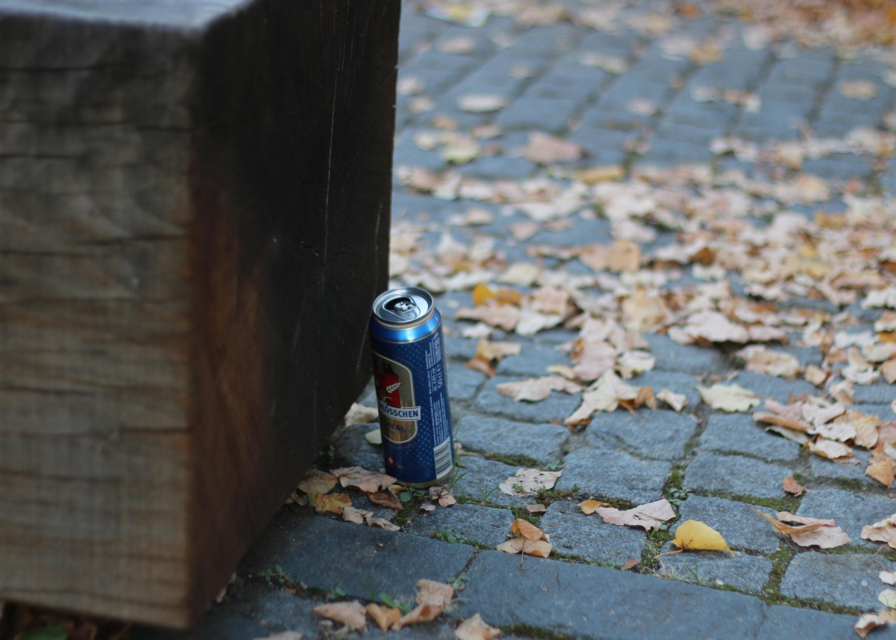

In [27]:
# top(sample1)
# sample1.reshape((1, 2, 0))
sample2 = sample1 / sample1.max()
x = torch.tensor(sample2)#.permute((1, 2, 0))
top(x)

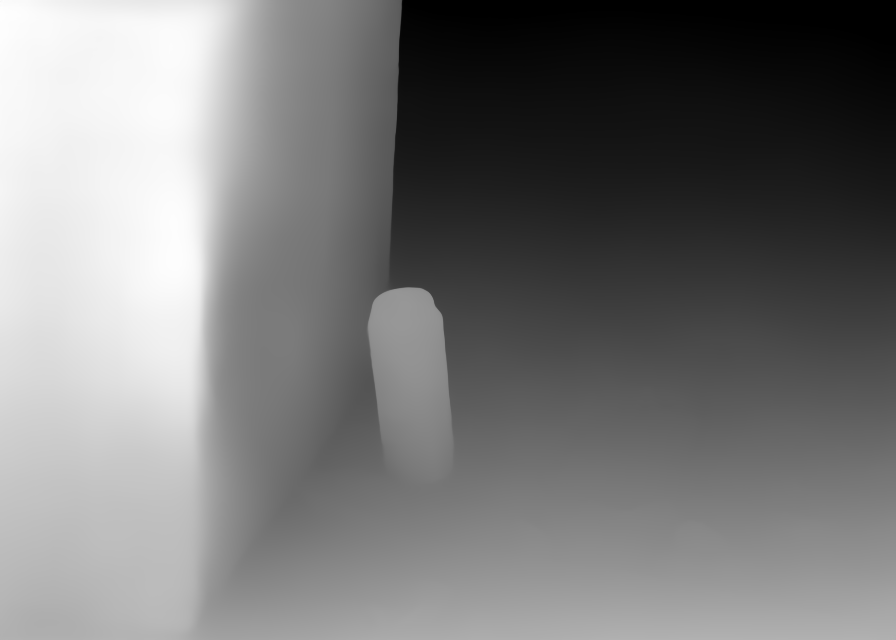

In [7]:
top(prediction / prediction.max())

In [8]:
import lpips
loss_fn_alex = lpips.LPIPS(net='alex')

import torch
img0 = torch.zeros(2, 3, 768, 1024) # image should be RGB, IMPORTANT: normalized to [-1,1]
img1 = torch.ones(2, 3, 768, 1024)
d = loss_fn_alex(img0, img1).mean()
d

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/ubuntu/anaconda3/envs/max_2_0/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


tensor(0.3901, grad_fn=<MeanBackward0>)

In [ ]:
from __future__ import absolute_import, division, print_function
# https://github.com/Soester10/Bokeh-Rendering-with-Vision-Transformers/blob/main/train.py

import PIL.Image as pil
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# feed_width = 768
# feed_height =  512
feed_height = 192 # 384
feed_width = 256 # 512
batch_size = 8#0


class bokehDataset(Dataset):
    
    def __init__(self, csv_file,root_dir, transform=None):
        
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # bok = pil.open(self.root_dir + self.data.iloc[idx, 0][1:]).convert('RGB')
        # org = pil.open(self.root_dir + self.data.iloc[idx, 1][1:]).convert('RGB')
            

        bok = util.io.read_image(self.root_dir + self.data.iloc[idx, 0][1:])
        org = util.io.read_image(self.root_dir + self.data.iloc[idx, 1][1:])

        if self.transform : 
            bok = self.transform({"image": bok})["image"]
            org = self.transform({"image": org})["image"]


        # print(type())
        bok = torch.from_numpy(bok)#.unsqueeze(0)
        # bok = bok.to(memory_format=torch.channels_last)
        # bok = bok.half()

        org = torch.from_numpy(org)#.unsqueeze(0)
        # org = org.half()
        # org = org.to(memory_format=torch.channels_last).half()

        return (bok, org)

# transform1 = transforms.Compose([
#     transforms.ToTensor(),
# ])
# transform2 = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=1),
#     transforms.ToTensor(),
# ])
# transform3 = transforms.Compose([
#     transforms.RandomVerticalFlip(p=1),
#     transforms.ToTensor(),
# ])

normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

net_w = net_h = 128

transform5 = Compose(
    [
        Resize(
            net_w,
            net_h,
            resize_target=None,
            keep_aspect_ratio=True,
            ensure_multiple_of=32,
            resize_method="minimal",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        normalization,
        PrepareForNet(),
    ]
)

trainset1 = bokehDataset(csv_file = '../MegaDepth/Bokeh_Data/train.csv', root_dir = '.',transform = transform5)
# trainset1 = bokehDataset(csv_file = './Bokeh_Data/train.csv', root_dir = '.',transform = transform1)
# trainset2 = bokehDataset(csv_file = './Bokeh_Data/train.csv', root_dir = '.',transform = transform2)
# trainset3 = bokehDataset(csv_file = './Bokeh_Data/train.csv', root_dir = '.',transform = transform3)

# trainloader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([trainset1,trainset2,trainset3]), batch_size=batch_size,
#                                           shuffle=True, num_workers=4)
trainloader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([trainset1]), batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = bokehDataset(csv_file = '../MegaDepth/Bokeh_Data/test.csv',  root_dir = '.', transform = transform5)
# testset = bokehDataset(csv_file = './Bokeh_Data/test.csv',  root_dir = '.', transform = transform1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=4)


In [ ]:
# for i, data in enumerate(trainloader, 0):
#     bok,  org = data
#     print(bok.shape)
#     print(bok.shape)
#     break


In [ ]:
device = 'cuda'
learning_rate = 0.00001
                                                  
MSE_LossFn = nn.MSELoss()
L1_LossFn = nn.L1Loss()

start_ep = 0

# model = torch.compile(model)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [ ]:
#  l; l;as jk sd;l

In [ ]:
import wandb
wandb.login(key="aeedb9e66ea2d25890e881e26dc8fb340bbfa00e", relogin=True)

id="DPT_5_identity_red"

wandb.init(
    project="diploma",
    
    tags=['DPT'],
    #  resume=True
    id=id
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc
wandb: Currently logged in as: maxkuz. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.watch(model, log_freq=10, log='all')


[]

In [ ]:
def train(dataloader):
    model.train()
    running_loss = 0

    for i,data in enumerate(tqdm(dataloader), 0):
        if i > 150:
            break
        bok,  org = data
        bok,  org = bok.to(device) , org.to(device)

        optimizer.zero_grad()
        
        bok_pred = model.forward(org)
        
        bok = bok[:, 0:1, :, :]
        org = org[:, 0:1, :, :]


        # bok_pred = bok_pred / bok_pred.max()

        # loss = (1-ms_ssim(bok_pred, bok))
        loss = L1_LossFn(bok_pred, org)
        # loss = MSE_LossFn(bok_pred, bok)

        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        if (i % 40 == 0):
            original = wandb.Image(org[0])
            pred = wandb.Image(bok_pred[0])
            ground_truth = wandb.Image(bok[0])
            wandb.log({
                "Train/L1_loss": loss,
                "Train/orig": original,
                "Train/pred": pred,
                "Train/bokeh": ground_truth
                })

    wandb.log({
        "Train/running_loss": running_loss/len(dataloader)})


def val(dataloader, e):
    model.eval()
    running_l1_loss = 0
    running_ms_loss = 0

    with torch.no_grad():
        for i,data in enumerate(tqdm(dataloader), 0):
            if i > 40:
                break
            bok , org = data 
            bok , org = bok.to(device) , org.to(device)
            bok_pred = model.forward(org)

            bok = bok[:, 0:1, :, :]
            org = org[:, 0:1, :, :]
            
            # bok_pred = bok_pred / bok_pred.max()

            # loss = (1-ms_ssim(bok_pred, bok))
            l1_loss = L1_LossFn(bok_pred, org)
            # loss = MSE_LossFn(bok_pred, bok)
                
            if i % 10 == 0:
                original = wandb.Image(org[0])
                pred = wandb.Image(bok_pred[0])
                ground_truth = wandb.Image(bok[0])
                wandb.log({
                    "Val/loss": l1_loss,
                    "Val/orig": original,
                    "Val/pred": pred,
                    "Val/bokeh": ground_truth,
                    })

            running_l1_loss += l1_loss.item()
            # running_ms_loss += ms_loss.item()

    wandb.log({
        "Val/L1_loss": running_l1_loss/len(dataloader),
        "Val/MS_loss": running_ms_loss/len(dataloader),
        "Val/Epoch": e
        })

    print ('Validation l1 Loss: ',running_l1_loss/len(dataloader))   
    # print ('Validation ms Loss: ',running_ms_loss/len(dataloader), '\n')

    # torch.save(model.state_dict(), f'./weights/{id}_'+str(e)+'.pt')


for epoch in range(start_ep, 500):
    print("\nEpoch:", epoch)
    

    with torch.no_grad():
        val(testloader, epoch)

    train(trainloader)



Epoch: 0


  0%|          | 0/37 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/max_2_0/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([8, 1, 128, 128])) that is different to the input size (torch.Size([8, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
 32%|███▏      | 12/37 [00:03<00:07,  3.48it/s]


KeyboardInterrupt: 